In [1]:
from bs4 import BeautifulSoup
import re
import os
from tqdm import tqdm
from collections import Counter
import torch
import time
import gensim
import pymorphy2
import numpy as np

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [3]:
proj_types, proj_names, proj_descrs = [],[],[]
folders = os.listdir('texts')
for folder in tqdm(folders):
    f = open(f"texts/{folder}/choose", "r", encoding="utf-8")
    contents = f.read()
    soup = BeautifulSoup(contents, 'lxml')
    founded = soup.find_all('div', {'class': 'lr-project-value'})
    proj_types.append( re.sub(r'[\n\t]', '', founded[1].get_text().lower()) )
    proj_names.append( re.sub(r'[\n\t]', '', founded[3].get_text().lower()) )
    proj_descrs.append( re.sub(r'[\n\t]', '', founded[4].get_text().lower()) )
    f.close()
    


100%|██████████| 6605/6605 [00:33<00:00, 195.32it/s]


In [4]:
from collections import defaultdict

In [5]:
types_dict = defaultdict(int)
for proj_type in (proj_types):
    types_dict[proj_type] += 1
    
for key, value in sorted(types_dict.items(), key=lambda item: item[1], reverse = True):
    print("%s: %s" % (key, value))

другое: 2206
просвещение и образование — новые форматы и темы: 1851
зож: профилактика, а не лечение: 570
семья: сохранение традиций и ценностей: 533
искусственный интеллект и современные технологии на службе обществу: 523
75-я годовщина со дня победы в великой отечественной войне: 308
правовая защита граждан и предпринимателей: 216
проекты в области науки: 159
внутренний туризм: новые формы, новые маршруты: 157
культурно-историческое наследие россии: 82


In [6]:
topic = 'просвещение и образование — новые форматы и темы'

In [7]:
names, descrs = [], []
for i in range( len(proj_names) ):
    if proj_types[i] == topic:
        names.append( proj_names[i] )
        descrs.append( proj_descrs[i] )

In [8]:
len(names)

1851

In [9]:
line = 'колхоз37: пошел в кино и закрыл2'
line = re.sub(r'([а-яА-Яa-zA-Z])([\d\:]+)', r'\1', line)
line

'колхоз пошел в кино и закрыл'

In [10]:
# process text
for i in range( len(names) ):
    ### NAMES
    # lowcase, no , - : ; ( ) " ' « » and .
    #line = names[i].lower()
    line = names[i]
    line = re.sub(r'[\,\-\:\;\(\)\"\«\»\.\!\?\\\/]', ' ', line)
    line = re.sub(r"\'", ' ', line)
    # change all ... to space
    line = re.sub(r'\.+', ' ', line)
    # no doublespace
    line = re.sub(r' +', ' ', line)
    # no space after .
    #line = re.sub(r'\. ', '.', line)
    names[i] = line.strip()
    
    ### DESCRS
    # lowcase, no , - : ; ( ) " ' « » keep .
    #line = descrs[i].lower()
    line = descrs[i]
    line = re.sub(r'[\,\-\:\;\(\)\"\«\»\\\/]', ' ', line)
    line = re.sub(r"\'", ' ', line)
    # change all ... to .
    line = re.sub(r'\.+', '.', line)
    # ё -> е
    line = re.sub(r'ё', 'е', line)
    # ! > .
    line = re.sub(r'[\!\?]', ".", line)
    # remove all digits and symbols connected to words
    line = re.sub(r'([а-яА-Яa-zA-Z])([\d\:\*]+)', r'\1', line)
    # no doublespace
    line = re.sub(r' +', ' ', line)
    # no space after .
    line = re.sub(r'\. ', '.', line)
    # change all ... to .
    line = re.sub(r'\.+', '.', line)
    descrs[i] = line.strip()

In [11]:
names[0]

'на базе районного клуба культуры организовать курсы и индивидуальные занятия по использованию современных цифровых технологий для пожилых людей'

In [12]:
descrs[0]

'целью проекта является создание условий для социальной адаптации пожилых людей к использованию современных цифровых технологий улучшение качества их жизни.основные направления обучения получение государственных услуг в электронном виде социальные сети и мессенджеры для общения с близкими использование электронной почты поиск новостного и мультимедийного контента информационная безопасность правила поведения в сети интернет.обучение будет иметь в большей степени практический уклон.проект планируется осуществить на базе районных учреждений культуры.по словам сотрудников нашего районного клуба не все пожилые люди успешно воспринимают существующие курсы компьютерной грамотности им не хватает практических занятий и индивидуального подхода а также умений пользоваться другими гаджетами смартфонами планшетами современными телевизорами.часто требуется помощь по настройке устройств.руководство клуба известит пожилых людей района и соберет заявки желающих.планирую создать учебный план печатные м

### Пробуем просто все предложения данной тематике собрать в кучу

In [13]:
all_sents = []
max_slen = 0
for i in range(len(descrs)):
    sents = descrs[i].split('.')
    for j in range(len(sents)):
        sents[j] = sents[j].strip()
        slen = len(sents[j])
        if slen > 0:
            all_sents.append(sents[j])

In [14]:
len(all_sents)

31656

In [15]:
all_sents[1]

'основные направления обучения получение государственных услуг в электронном виде социальные сети и мессенджеры для общения с близкими использование электронной почты поиск новостного и мультимедийного контента информационная безопасность правила поведения в сети интернет'

In [16]:
text = ' '.join(all_sents)
text = re.sub(r'  ', ' ', text)  # убрать двойные пробелы
ALL_WORDS = set(text.strip().split(' '))
len(ALL_WORDS)

43768

In [17]:
c = Counter(text.split(' '))
c.most_common(10)

[('и', 21758),
 ('в', 18693),
 ('на', 7544),
 ('с', 6533),
 ('для', 5374),
 ('по', 4119),
 ('не', 3525),
 ('проекта', 3469),
 ('к', 3143),
 ('как', 2428)]

In [18]:
# удаляем слова с числом повторений меньше 2
todelete = set()
for i, n in c.items():
    if n < 2:
        todelete.add(i)
        
for i in todelete:
    del c[i]

In [19]:
len(c.keys())

22050

In [20]:
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('embed_models/183 - ruwikiruscorpora-func_upos_skipgram_300_5_2019/model.bin', binary=True)
model_w2v_weights = torch.FloatTensor(model_w2v.vectors).to(dev)

In [21]:
#weights = torch.FloatTensor(model.vectors) # formerly syn0, which is soon deprecated
EMBED_SIZE = model_w2v.vector_size
EMBED_SIZE

300

In [22]:
WORDS_COUNT = len(c.keys())
ALL_WORDS = set([w for w, _ in c.most_common(WORDS_COUNT)])
INDEX_TO_WORD = ['<pad>', '<miss>'] + list(ALL_WORDS)
len(INDEX_TO_WORD)

22052

In [23]:
WORD_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_WORD)}
INDEX_TO_WORD[:10]

['<pad>',
 '<miss>',
 'гражданам',
 'поэтому',
 'риска',
 'елец',
 'типа',
 'полугода',
 'журналиста',
 'опорой']

In [24]:
# create word_index to embedding array
index_to_embedding = torch.zeros([len(INDEX_TO_WORD), EMBED_SIZE], dtype=torch.float32)
cotags = {'ADJF':'ADJ', # pymorphy2: word2vec 
'ADJS' : 'ADJ', 
'ADVB' : 'ADV', 
'COMP' : 'ADV', 
'GRND' : 'VERB', 
'INFN' : 'VERB', 
'NOUN' : 'NOUN', 
'PRED' : 'ADV', 
'PRTF' : 'ADJ', 
'PRTS' : 'VERB', 
'VERB' : 'VERB',
# my
'CONJ' : 'ADV',
'INTJ' : 'NOUN',
'PREP' : 'PROPN',
'NUMR' : 'NUM',
'PRCL' : 'PROPN',
'NPRO' : 'PRON'
         }

In [25]:
morph = pymorphy2.MorphAnalyzer()
PAD_WORD = 'сингулярность'
MISS_WORD = 'хрень'
#index_to_embedding[0] = torch.from_numpy( model_w2v[PAD_WORD+"_NOUN"] )
index_to_embedding[0] = torch.zeros(EMBED_SIZE)
index_to_embedding[1] = torch.from_numpy( model_w2v[MISS_WORD+"_NOUN"] )

cnotfound_in_pymorphy = 0
cnotfound_in_w2v = 0
not_found_in_pymorphy = []
not_found_in_w2v = []

for i in tqdm( range(2,len(INDEX_TO_WORD)) ):
    word = INDEX_TO_WORD[i]
    #print (word)
    info = morph.parse(word)[0]
    if ('UNKN' in info.tag) or ('LATN' in info.tag) or ('NUMB' in info.tag) or ('PNCT' in info.tag) or ('ROMN' in info.tag):
        info = morph.parse(MISS_WORD)[0]
        cnotfound_in_pymorphy += 1
        not_found_in_pymorphy.append(word)
        
    p_speech = cotags[info.tag.POS]
    w2v_form = info.normal_form + "_" + p_speech
    
#     #debug
#     if w2v_form.startswith('касаться'):
#         print (morph.parse(word))
    
    if w2v_form in model_w2v:
        index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
    else:
        if p_speech == 'ADV':
            p_speech = 'ADJ'
            w2v_form = info.normal_form + "_" + p_speech
            if w2v_form in model_w2v:
                index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
            else:
                cnotfound_in_w2v += 1
                not_found_in_w2v.append(w2v_form)
                index_to_embedding[i] = index_to_embedding[1]  # MISS_WORD
        else:
            if p_speech == 'ADJ':
                p_speech = 'ADV'
                w2v_form = info.normal_form + "_" + p_speech
                if w2v_form in model_w2v:
                    index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
                else:
                    cnotfound_in_w2v += 1
                    not_found_in_w2v.append(w2v_form)
                    index_to_embedding[i] = index_to_embedding[1]  # MISS_WORD

print (f'Not found pmorphy2: {cnotfound_in_pymorphy}, not found in w2v: {cnotfound_in_w2v}')

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
100%|██████████| 22050/22050 [00:03<00:00, 7190.33it/s]

Not found pmorphy2: 665, not found in w2v: 560


In [26]:
word_form = model_w2v.similar_by_vector( index_to_embedding[10].numpy(), 1)[0][0]
word = re.sub(r'([а-яА-Яa-zA-Z])_(.+)', r'\1', word_form)
word

'превращение'

In [27]:
INDEX_TO_WORD[10]

'превращение'

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([8.039e+03, 7.068e+03, 6.298e+03, 4.411e+03, 2.430e+03, 1.376e+03,
        7.910e+02, 4.350e+02, 2.550e+02, 1.670e+02, 1.070e+02, 6.300e+01,
        4.900e+01, 3.500e+01, 2.700e+01, 2.100e+01, 1.500e+01, 6.000e+00,
        5.000e+00, 1.300e+01, 8.000e+00, 5.000e+00, 6.000e+00, 2.000e+00,
        4.000e+00, 4.000e+00, 5.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   6.98,  12.96,  18.94,  24.92,  30.9 ,  36.88,  42.86,
         48.84,  54.82,  60.8 ,  66.78,  72.76,  78.74,  84.72,  90.7 ,
         96.68, 102.66, 108.64, 114.62, 120.6 , 126.58, 132.56, 138.54,
        144.52, 150.5 , 156.48, 162.46, 168.44, 174.42, 180.4 , 186.38,
        192.36, 198.34, 204.32, 210.3 , 216.28, 222.26, 228.24, 234.22,
        240.2 , 

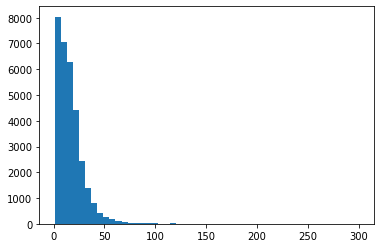

In [29]:
# распреление длины слов в предложении
plt.hist([len(s.split(' ')) for s in all_sents], bins=50)

In [30]:
MAX_LEN = 40

In [31]:
type(WORD_TO_INDEX)

dict

In [32]:
X = torch.zeros((len(all_sents), MAX_LEN, EMBED_SIZE), dtype=torch.float32)
# готовим матрицу - строка - предложение, столбец - эмбеддинг слова в этой позиции
for i in tqdm(range(len(all_sents))):
    for j, w in enumerate(all_sents[i].split(' ')):
        if j >= MAX_LEN:
            break
        X[i, j, 0:EMBED_SIZE] = index_to_embedding[ WORD_TO_INDEX.get(w, 1) ]
        
X = X.to(dev)

100%|██████████| 31656/31656 [00:02<00:00, 11207.09it/s]


In [33]:
X.shape

torch.Size([31656, 40, 300])

In [34]:
BATCH_SIZE = 10

In [35]:
class Network(torch.nn.Module):

    def __init__(self, dev, model_w2v_weights):
        super(Network, self).__init__()
        self.dev = dev
        #self.word_embeddings = torch.nn.Embedding.from_pretrained(model_w2v_weights).to(self.dev)
        self.gru = torch.nn.LSTM(EMBED_SIZE, EMBED_SIZE, num_layers = 4, batch_first=True).to(self.dev)
        #self.hidden2tag = torch.nn.Linear(128, len(INDEX_TO_WORD)).to(self.dev)
        
    def get_embeddings(self,sentences):
        csentences = sentences.size()[0]
        cwords = sentences.size()[1]
        embeds = torch.zeros(csentences, cwords, EMBED_SIZE).to(self.dev)
        for i in range(csentences):  
            for k in range(cwords):
                if sentences[i][k] == 0:
                    embeds[i][k] = self.word_embeddings[0]
                    break
                embeds[i][k] = torch.FloatTensor ([ emb for emb in self.word_embeddings[ sentences[i][k] ] ])
        return embeds

    def forward(self, sentences):
        #embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(sentences)
        #tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        tag_space = gru_out
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state
    
    def forward_state(self, sentences, state):
        #embeds = self.get_embeddings(sentences)
        #embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(sentences, state)
        #tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        tag_space = gru_out
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

In [36]:
model = Network(dev, model_w2v_weights)
model.forward(X[0:1])[0].shape

torch.Size([1, 40, 300])

In [37]:
def generate_sentence(line):
    sentence = line.split(' ')
    #sentence = ['к', 'а', 'к', ' ', 'р', 'а', 'н', 'о',' ']
    state = None
    X = torch.zeros((1, MAX_LEN, EMBED_SIZE), dtype=torch.float32).to(dev)
    for i in range(MAX_LEN):
        #X = torch.Tensor([[WORD_TO_INDEX[sentence[i]]]]).type(torch.long)
        #X = torch.Tensor([[WORD_TO_INDEX.get(sentence[i],WORD_TO_INDEX['<miss>'])]]).type(torch.long)
        X[0, i, 0:EMBED_SIZE] = index_to_embedding[ WORD_TO_INDEX.get(sentence[i], 1) ]
        #get(w, WORD_TO_INDEX['<miss>']
        #X = X.to(dev)
        if i == 0:
            result, state = model.forward(X)
        else:
            result, state = model.forward_state(X, state)
        prediction = result[0, -1, :].to('cpu')
        #index_of_prediction = prediction.argmax()
#         if i >= len(sentence) - 1:
#             if index_of_prediction == 0:
#                 break

        word_form = model_w2v.similar_by_vector(prediction.detach().numpy(), 1)[0][0]
        word = re.sub(r'([а-яА-Яa-zA-Z])_(.+)', r'\1', word_form)
        sentence.append(word)
        
    line = ' '.join(sentence)
    line = re.sub(r'none.*$', '', line)
    print(line)

In [41]:
lrate = 0.01

criterion = torch.nn.CosineEmbeddingLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lrate)
#optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

In [42]:
generate_sentence('проект направлена на')

проект направлена на допекать допекать допекать пожинавать пожинавать пожинавать пожинавать пожинавать пожинавать пожинавать пожинавать пожинавать -бизнес -бизнес мишкинский мишкинский неизвестность неизвестность неизвестность грустить грустить грустить грустить грустить грустить наташа эйнар эйнар эйнар эйнар эйнар валькирия вьюга вьюга вьюга тигрица стена racers racers хрень


In [48]:
count = 0
target = torch.ones(EMBED_SIZE).to(dev)

for ep in range(2000):
    
    start = time.time()
    train_loss = 0.
    train_passed = 0
    
    for i in range(int(len(X) / BATCH_SIZE)):
        batch = X[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        X_batch = batch[:, :-1]
        #Y_batch = batch[:, 1:].flatten()
        Y_batch = batch[:, 1:]

        optimizer.zero_grad()
        answers, _ = model.forward(X_batch)
        #answers = answers.view(-1, len(INDEX_TO_WORD))
        loss = criterion(answers, Y_batch, target)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1
    end = time.time()
    
    count += 1
    if count == 1:
        count = 0
        trloss = train_loss / train_passed
        print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, end - start, trloss))
        #generate_sentence('проект позволяет')

Epoch 0. Time: 19.030, Train loss: 0.509
Epoch 1. Time: 19.016, Train loss: 0.507
Epoch 2. Time: 19.038, Train loss: 0.506
Epoch 3. Time: 19.038, Train loss: 0.506
Epoch 4. Time: 19.077, Train loss: 0.506
Epoch 5. Time: 19.157, Train loss: 0.506
Epoch 6. Time: 19.169, Train loss: 0.505
Epoch 7. Time: 19.204, Train loss: 0.505
Epoch 8. Time: 19.211, Train loss: 0.505
Epoch 9. Time: 19.197, Train loss: 0.505
Epoch 10. Time: 19.173, Train loss: 0.505
Epoch 11. Time: 19.110, Train loss: 0.505
Epoch 12. Time: 19.095, Train loss: 0.505
Epoch 13. Time: 19.100, Train loss: 0.504
Epoch 14. Time: 19.083, Train loss: 0.504
Epoch 15. Time: 19.088, Train loss: 0.504
Epoch 16. Time: 19.079, Train loss: 0.504
Epoch 17. Time: 19.099, Train loss: 0.504
Epoch 18. Time: 19.097, Train loss: 0.504
Epoch 19. Time: 19.091, Train loss: 0.504
Epoch 20. Time: 19.099, Train loss: 0.504
Epoch 21. Time: 19.091, Train loss: 0.504
Epoch 22. Time: 19.126, Train loss: 0.504
Epoch 23. Time: 19.123, Train loss: 0.503
Ep

KeyboardInterrupt: 

In [49]:
generate_sentence('предлагается')

предлагается допекать допекать вымучивать вымучивать вымучивать валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе -бизнес -бизнес -бизнес -бизнес аида::ведищев неизвестность неизвестность акробатка эйнар вьюга вьюга вьюга вьюга вьюга доктор некромант некромант некромант некромант памела памела ботаническое ботаническое и докучаев::в::в оптимальный


In [50]:
generate_sentence('проект позволяет')

проект позволяет допекать урядников вымучивать подготовка урядников т.п т.п т.п т.п есть сверхразумный сверхразумный сверхразумный допекать нуженута порожденный порождать ,_PUNCT ,_PUNCT ;_PUNCT вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга некромант илай фэнтези ботаническое *2003_NUM докучаев::в::в хрень


In [51]:
generate_sentence('в нашей стране дети')

в нашей стране дети урядников урядников урядников урядников урядников 96-й урядников урядников урядников валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе напролом напролом круговерть круговерть экко экко пророчица пророчица пророчица пророчица пророчица пророчица пророчица пророчица пророчица вьюга вьюга илай drift drift происхождение хрень


In [52]:
generate_sentence('низкий уровень образования')

низкий уровень образования допекать урядников урядников валерий::меладзе вымучивать вымучивать валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе валерий::меладзе соткать разонравиться разонравиться порожденный ,_PUNCT ;_PUNCT груффало груффало вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга вьюга илай racers происхождение хрень


In [53]:
generate_sentence('проект способен')

проект способен допекать допекать вымучивать вымучивать везде значит натаскивать несравнимо несравнимо допекать допекать допекать допекать допекать допекать нуженута нуженута быть быть быть гипнос пророчица вьюга вьюга вьюга вьюга вьюга захвачять вьюга вьюга вьюга вьюга вьюга вьюга некромант памела сандор докучаев::в::в модернизировать хрень


In [59]:
descrs[105]


'предлагается создание платформы и онлайн курсов ориентированных на людей среднего возраста для повышения языковой финансовой и юридической грамотности.формат курсов будет открытый то есть доступный для всех без каких либо ограничений в том числе и территориальных.технология курсов будет соответствовать требованиям технологии массовых открытых онлайн курсов моок .лекции будут прочитаны ведущими специалистами и преподавателями в соответствующих областях.после каждой лекции будут тесты для самопроверки по пройденному материалу.в конце обучения будет предложено творческое задание для взаимного оценивания.обучающиеся успешно прошедшие обучение будут допущены до аттестации по итогам которой будут выжданы электронные сертификаты подтверждающие результаты обучения.'

In [54]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "model_allw_w2v_lstm4l-300-loss0d5.pt")

In [47]:
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load("model_allw_w2v_rnn1l-300-128-loss0d86.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']

#model.eval()
model.train()

Network(
  (word_embeddings): Embedding(248118, 300)
  (gru): GRU(300, 128, batch_first=True)
  (hidden2tag): Linear(in_features=128, out_features=44946, bias=True)
)

In [45]:
model.train()

Network(
  (word_embeddings): Embedding(248118, 300)
  (gru): GRU(300, 128, batch_first=True)
  (hidden2tag): Linear(in_features=128, out_features=44946, bias=True)
)

In [48]:
loss

tensor(1.0754, device='cuda:0', requires_grad=True)

In [164]:
c['преподаватели']

84

In [44]:
c['будет']

1283

In [48]:
c.most_common(500)

[('и', 21757),
 ('в', 18684),
 ('на', 7540),
 ('с', 6533),
 ('для', 5371),
 ('по', 4117),
 ('не', 3524),
 ('проекта', 3413),
 ('к', 3142),
 ('как', 2422),
 ('что', 2298),
 ('а', 2041),
 ('детей', 1997),
 ('из', 1893),
 ('о', 1651),
 ('проект', 1626),
 ('это', 1586),
 ('их', 1507),
 ('или', 1477),
 ('от', 1449),
 ('1', 1315),
 ('–', 1285),
 ('будет', 1283),
 ('у', 1203),
 ('образования', 1184),
 ('при', 1184),
 ('2', 1170),
 ('которые', 1116),
 ('за', 1075),
 ('также', 1052),
 ('3', 1010),
 ('развития', 987),
 ('но', 983),
 ('работы', 973),
 ('так', 973),
 ('обучения', 933),
 ('реализации', 926),
 ('жизни', 909),
 ('будут', 877),
 ('россии', 787),
 ('профессии', 767),
 ('может', 764),
 ('создание', 763),
 ('области', 763),
 ('людей', 759),
 ('деятельности', 758),
 ('быть', 735),
 ('только', 709),
 ('т', 708),
 ('то', 705),
 ('рамках', 705),
 ('до', 705),
 ('можно', 704),
 ('школьников', 701),
 ('более', 693),
 ('время', 686),
 ('проведение', 679),
 ('все', 676),
 ('4', 669),
 ('они', 66

In [162]:
# save descrs to disk
import pandas as pd
df = pd.DataFrame(descrs)
df.to_csv("descrs.csv", encoding = 'utf8')


### Пробуем эмбеддинги word2vec


ModuleNotFoundError: No module named 'gensim'